In [6]:
import os
import zipfile
import random
from glob import glob
 
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
cd drive/MyDrive/Colab\ Notebooks/BelgiumTraficSign

/content/drive/MyDrive/Colab Notebooks/BelgiumTraficSign


In [ ]:
# !wget -O BelgiumTSC.zip https://www.dropbox.com/s/nl7w2u523zfymlh/BelgiumTSC.zip?dl=1 
# dataset_zip = 'BelgiumTSC.zip'
# zip_ref = zipfile.ZipFile(dataset_zip, 'r')
# zip_ref.extractall()
# zip_ref.close()

--2021-05-20 18:10:35--  https://www.dropbox.com/s/nl7w2u523zfymlh/BelgiumTSC.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/nl7w2u523zfymlh/BelgiumTSC.zip [following]
--2021-05-20 18:10:36--  https://www.dropbox.com/s/dl/nl7w2u523zfymlh/BelgiumTSC.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc387391284dd027640d18f69208.dl.dropboxusercontent.com/cd/0/get/BO00Bl8KxXZTiKP1xrZO88r4UphUHm9zeAnewNoqsrB3mKgn1qCNoz4u3B_4U4SHNqIRE0LbfBz2xgVSR_4Rrms3k3do4MDAhPFswTenPksWI5V9U4FXqDsrkYhelXshVsZLtB9RzJIIsvDieRYVRTJo/file?dl=1# [following]
--2021-05-20 18:10:36--  https://uc387391284dd027640d18f69208.dl.dropboxusercontent.com/cd/0/get/BO00Bl8KxXZTiKP1xrZO88r4UphUHm9zeAnewNoqsrB3mKgn1qCNoz4u3B_4U4SHNqIRE0LbfBz2xgVSR_

In [8]:
TRAINING_DATA_DIR = 'BelgiumTSC/Training'
TESTING_DATA_DIR = 'BelgiumTSC/Testing'
TARGET_SIZE = 100
BASE_EPOCHS = 50
BASE_LR = 0.01


In [9]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAINING_DATA_DIR,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (TARGET_SIZE,TARGET_SIZE),
    shuffle = True,
    batch_size = 8,
    seed = 123
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TESTING_DATA_DIR,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (TARGET_SIZE, TARGET_SIZE),
    shuffle = False,
    batch_size = 8
)

NUM_CLASSES = len(training_ds.class_names)

Found 4572 files belonging to 62 classes.
Found 2520 files belonging to 62 classes.


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_prefetcher = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_prefetcher = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
def plot_history(history):
  acc      = history.history['accuracy' ]
  val_acc  = history.history['val_accuracy' ]
  loss     = history.history['loss' ]
  val_loss = history.history['val_loss' ]
  epochs   = range(len(acc))

  plt.figure(figsize=(20, 5))
  plt.tight_layout() 
  sns.set(style = 'whitegrid', font_scale = 2)

  plt.subplot(1, 2, 1)
  plt.plot  (epochs, acc, label='training' )
  plt.plot  (epochs, val_acc, label='testing' )
  plt.annotate('%0.4f' % acc[-1], (epochs[-1],acc[-1]), textcoords="offset points", xytext=(0,10), ha='center')
  plt.annotate('%0.4f' % val_acc[-1], (epochs[-1],val_acc[-1]), textcoords="offset points", xytext=(0,10), ha='center')

  max_val_acc = max(val_acc)
  max_val_idx = list(val_acc).index(max_val_acc)
  max_val_epoch = epochs[max_val_idx]
  plt.scatter([max_val_epoch], [max_val_acc], color='maroon')
  plt.annotate("%0.4f" % max_val_acc, (max_val_epoch, max_val_acc), color='maroon')

  plt.title ('Training and testing accuracy')
  plt.ylim([0.5, 1.05])
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot  ( epochs,     loss, label='training'  )
  plt.plot  ( epochs, val_loss, label='testing' )
  plt.annotate('%0.4f' % loss[-1], (epochs[-1],loss[-1]), textcoords="offset points", xytext=(0,10), ha='center')
  plt.annotate('%0.4f' % val_loss[-1], (epochs[-1],val_loss[-1]), textcoords="offset points", xytext=(0,10), ha='center')
  plt.title ('Training and testing loss'   )
  plt.legend()



In [44]:
class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.99):
        print("\n 99% acc reached")
        self.model.stop_training = True
custom_callbacks = CustomCallbacks()

##ConvNetV1

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(TARGET_SIZE, TARGET_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE,3)),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    training_prefetcher,
    epochs = BASE_EPOCHS,
    verbose = 1,
    validation_data = testing_prefetcher
)



Epoch 1/50
572/572 [==============================] - 22s 34ms/step - loss: 3.6851 - accuracy: 0.0910 - val_loss: 2.8120 - val_accuracy: 0.3095
Epoch 2/50
572/572 [==============================] - 6s 11ms/step - loss: 2.4592 - accuracy: 0.3568 - val_loss: 2.3098 - val_accuracy: 0.3901
Epoch 3/50
572/572 [==============================] - 6s 11ms/step - loss: 1.8796 - accuracy: 0.4580 - val_loss: 1.6677 - val_accuracy: 0.5302
Epoch 4/50
572/572 [==============================] - 6s 11ms/step - loss: 1.4166 - accuracy: 0.5784 - val_loss: 1.3773 - val_accuracy: 0.6139
Epoch 5/50
572/572 [==============================] - 6s 11ms/step - loss: 1.1784 - accuracy: 0.6324 - val_loss: 1.3838 - val_accuracy: 0.6044
Epoch 6/50
572/572 [==============================] - 6s 11ms/step - loss: 1.0515 - accuracy: 0.6749 - val_loss: 1.9463 - val_accuracy: 0.5060
Epoch 7/50
572/572 [==============================] - 6s 11ms/step - loss: 0.9492 - accuracy: 0.7076 - val_loss: 1.3268 - val_accuracy: 0.650

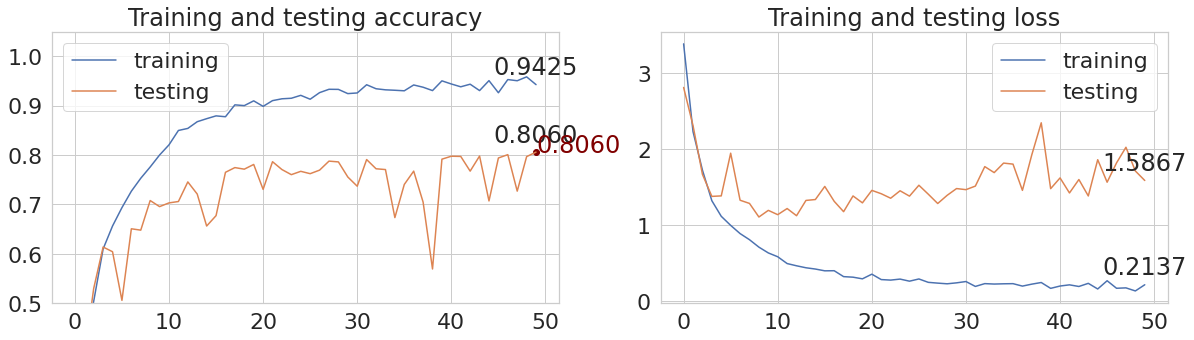

In [16]:
plot_history(history)

##ConvNetV2

In [17]:
model_v2 = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(TARGET_SIZE, TARGET_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_v2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_v2 = model_v2.fit(
    training_prefetcher,
    epochs = BASE_EPOCHS,
    verbose = 1,
    validation_data = testing_prefetcher,
)

Epoch 1/50
572/572 [==============================] - 10s 15ms/step - loss: 3.7455 - accuracy: 0.1207 - val_loss: 2.7295 - val_accuracy: 0.2992
Epoch 2/50
572/572 [==============================] - 8s 14ms/step - loss: 1.5530 - accuracy: 0.6151 - val_loss: 0.9253 - val_accuracy: 0.7460
Epoch 3/50
572/572 [==============================] - 8s 14ms/step - loss: 0.6315 - accuracy: 0.8438 - val_loss: 0.5138 - val_accuracy: 0.8599
Epoch 4/50
572/572 [==============================] - 8s 14ms/step - loss: 0.3182 - accuracy: 0.9285 - val_loss: 0.6107 - val_accuracy: 0.8631
Epoch 5/50
572/572 [==============================] - 8s 14ms/step - loss: 0.1618 - accuracy: 0.9645 - val_loss: 0.5216 - val_accuracy: 0.8841
Epoch 6/50
572/572 [==============================] - 8s 14ms/step - loss: 0.0960 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.8905
Epoch 7/50
572/572 [==============================] - 8s 14ms/step - loss: 0.0718 - accuracy: 0.9830 - val_loss: 0.3596 - val_accuracy: 0.913

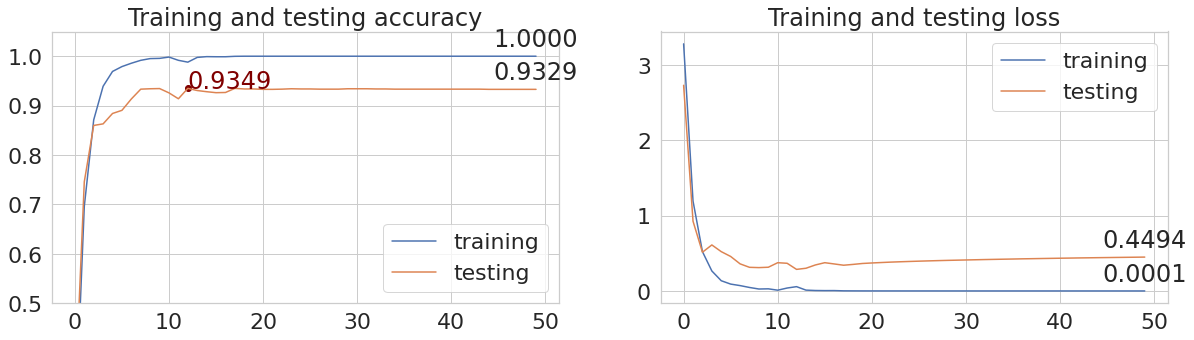

In [18]:
plot_history(history_v2)

##ConvNetV3

In [19]:
model_v3 = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(TARGET_SIZE, TARGET_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_v3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_v3 = model_v3.fit(
    training_prefetcher,
    epochs = BASE_EPOCHS,
    verbose = 1,
    validation_data = testing_prefetcher
)

Epoch 1/50
572/572 [==============================] - 7s 12ms/step - loss: 3.8719 - accuracy: 0.0593 - val_loss: 3.5335 - val_accuracy: 0.0944
Epoch 2/50
572/572 [==============================] - 6s 11ms/step - loss: 3.2100 - accuracy: 0.2029 - val_loss: 2.8901 - val_accuracy: 0.1829
Epoch 3/50
572/572 [==============================] - 6s 11ms/step - loss: 2.5890 - accuracy: 0.2962 - val_loss: 2.7722 - val_accuracy: 0.1992
Epoch 4/50
572/572 [==============================] - 6s 11ms/step - loss: 2.2842 - accuracy: 0.3766 - val_loss: 2.7782 - val_accuracy: 0.1937
Epoch 5/50
572/572 [==============================] - 7s 11ms/step - loss: 1.9090 - accuracy: 0.4892 - val_loss: 2.2076 - val_accuracy: 0.3706
Epoch 6/50
572/572 [==============================] - 6s 11ms/step - loss: 1.4863 - accuracy: 0.5920 - val_loss: 1.5989 - val_accuracy: 0.5421
Epoch 7/50
572/572 [==============================] - 6s 11ms/step - loss: 1.1097 - accuracy: 0.6988 - val_loss: 1.2147 - val_accuracy: 0.6548

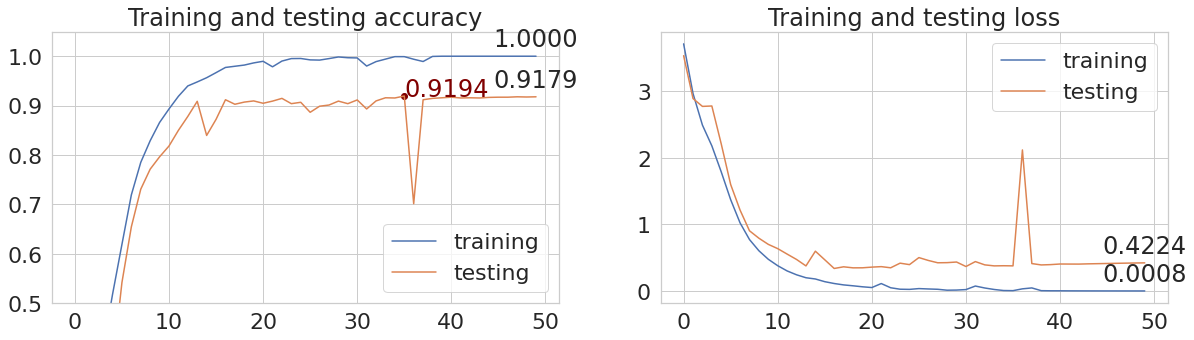

In [20]:
plot_history(history_v3)

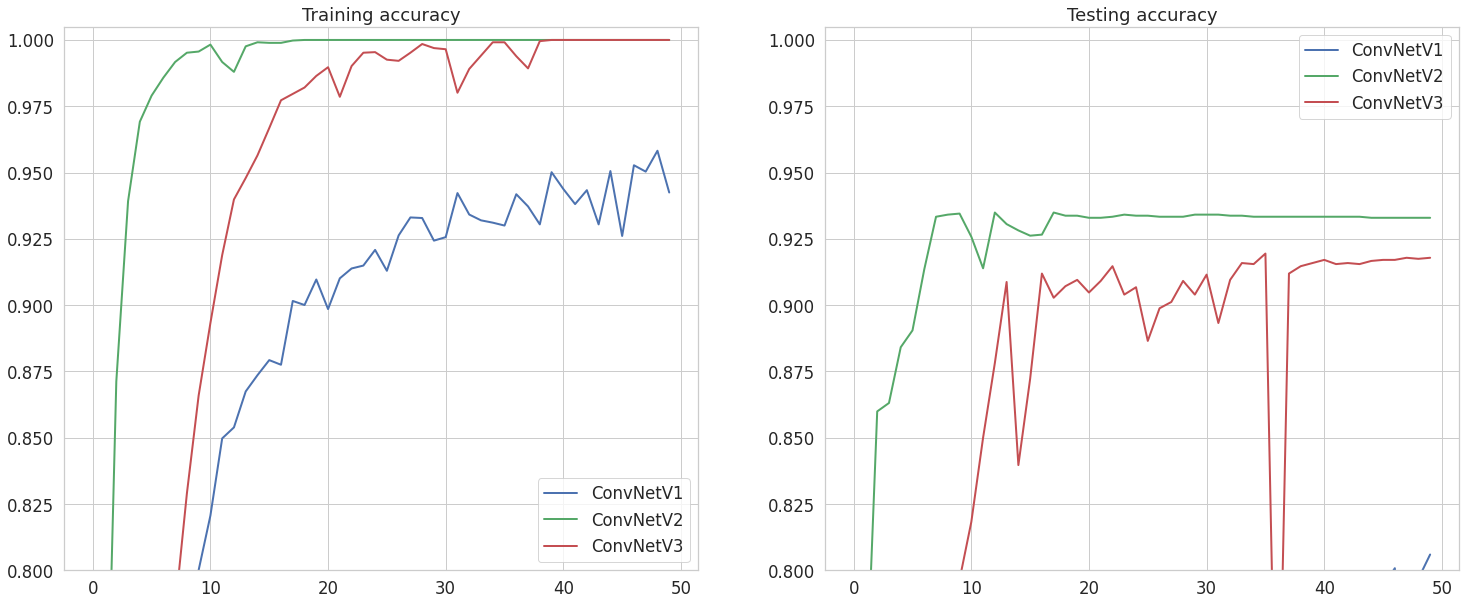

In [21]:
histories = {
             'ConvNetV1': history, 
             'ConvNetV2': history_v2, 
             'ConvNetV3': history_v3 
             }
colors = ['b', 'g', 'r']

sns.set(style = 'whitegrid', font_scale = 1.5)
plt.figure(figsize = (25,10))
plt.subplot(1, 2, 1)
for idx, (l, h) in enumerate(histories.items()):
  val_acc = h.history['accuracy']
  epochs = range(len(val_acc))

  plt.plot(epochs, val_acc, 'b', label='%s' % l, color = colors[idx], linewidth=2.0)
  plt.ylim([0.8, 1.005])
  plt.title('Training accuracy')
  plt.legend()

plt.subplot(1, 2, 2)
for idx, (l, h) in enumerate(histories.items()):
  val_acc = h.history['val_accuracy']
  epochs = range(len(val_acc))

  plt.plot(epochs, val_acc, 'b', label='%s' % l, color = colors[idx], linewidth=2.0)
  plt.title('Testing accuracy')
  plt.ylim([0.8, 1.005])
  plt.legend()

##ConvNetV2 + Dropout

In [25]:
model_v2_dropout = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(TARGET_SIZE, TARGET_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_v2_dropout.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_v2_dropout = model_v2_dropout.fit(
    training_prefetcher,
    epochs = BASE_EPOCHS,
    verbose = 1,
    validation_data = testing_prefetcher
)

Epoch 1/50
572/572 [==============================] - 9s 15ms/step - loss: 3.7397 - accuracy: 0.1106 - val_loss: 2.6213 - val_accuracy: 0.3044
Epoch 2/50
572/572 [==============================] - 8s 15ms/step - loss: 1.8086 - accuracy: 0.5755 - val_loss: 1.1428 - val_accuracy: 0.6714
Epoch 3/50
572/572 [==============================] - 8s 15ms/step - loss: 0.8443 - accuracy: 0.7990 - val_loss: 0.6909 - val_accuracy: 0.8198
Epoch 4/50
572/572 [==============================] - 8s 14ms/step - loss: 0.4906 - accuracy: 0.8821 - val_loss: 0.4960 - val_accuracy: 0.8575
Epoch 5/50
572/572 [==============================] - 8s 14ms/step - loss: 0.2895 - accuracy: 0.9252 - val_loss: 0.4666 - val_accuracy: 0.8825
Epoch 6/50
572/572 [==============================] - 8s 15ms/step - loss: 0.2077 - accuracy: 0.9487 - val_loss: 0.3004 - val_accuracy: 0.9254
Epoch 7/50
572/572 [==============================] - 8s 15ms/step - loss: 0.1521 - accuracy: 0.9612 - val_loss: 0.2748 - val_accuracy: 0.9385

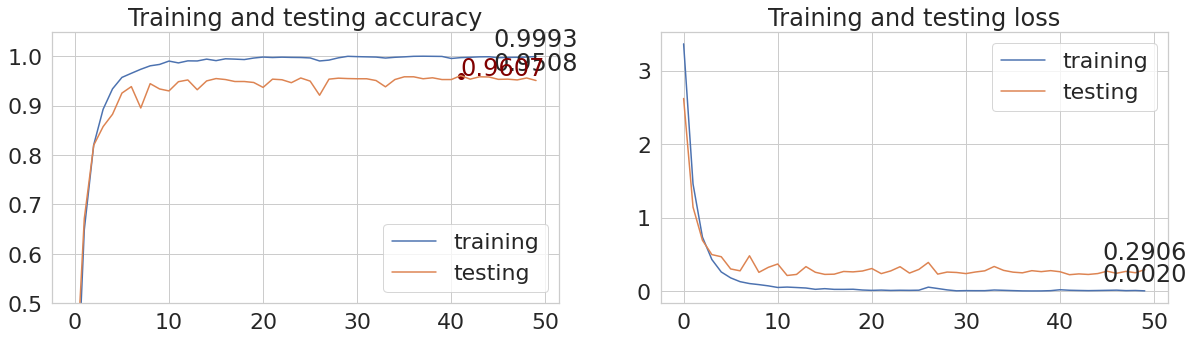

In [26]:
plot_history(history_v2_dropout)

##ConvNetV2 + preprocessing

In [27]:
model_v2_preprocessing = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(TARGET_SIZE, TARGET_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_v2_preprocessing.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_v2_preprocessing = model_v2_preprocessing.fit(
    training_prefetcher,
    epochs = BASE_EPOCHS,
    verbose = 1,
    validation_data = testing_prefetcher
)

Epoch 1/50
572/572 [==============================] - 11s 17ms/step - loss: 3.7533 - accuracy: 0.1061 - val_loss: 3.0259 - val_accuracy: 0.1270
Epoch 2/50
572/572 [==============================] - 9s 16ms/step - loss: 2.1895 - accuracy: 0.4528 - val_loss: 1.3813 - val_accuracy: 0.6111
Epoch 3/50
572/572 [==============================] - 9s 16ms/step - loss: 1.2061 - accuracy: 0.6833 - val_loss: 0.8453 - val_accuracy: 0.7385
Epoch 4/50
572/572 [==============================] - 9s 16ms/step - loss: 0.8180 - accuracy: 0.7771 - val_loss: 0.8272 - val_accuracy: 0.7754
Epoch 5/50
572/572 [==============================] - 9s 16ms/step - loss: 0.5763 - accuracy: 0.8368 - val_loss: 0.4333 - val_accuracy: 0.8750
Epoch 6/50
572/572 [==============================] - 9s 16ms/step - loss: 0.4279 - accuracy: 0.8881 - val_loss: 0.6213 - val_accuracy: 0.8262
Epoch 7/50
572/572 [==============================] - 9s 16ms/step - loss: 0.3421 - accuracy: 0.8981 - val_loss: 0.3380 - val_accuracy: 0.906

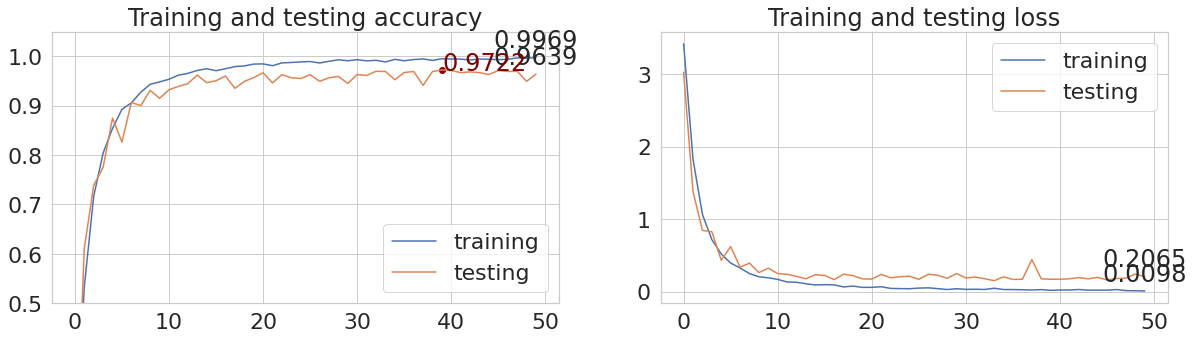

In [28]:
plot_history(history_v2_preprocessing)

##ConvNetV2 + dropout + preprecessing

In [29]:
model_v2_mix = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(TARGET_SIZE, TARGET_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_v2_mix.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_v2_mix = model_v2_mix.fit(
    training_prefetcher,
    epochs = BASE_EPOCHS,
    verbose = 1,
    validation_data = testing_prefetcher
)

Epoch 1/50
572/572 [==============================] - 11s 17ms/step - loss: 3.7520 - accuracy: 0.1102 - val_loss: 3.0012 - val_accuracy: 0.3020
Epoch 2/50
572/572 [==============================] - 9s 16ms/step - loss: 2.3749 - accuracy: 0.4043 - val_loss: 1.5909 - val_accuracy: 0.5397
Epoch 3/50
572/572 [==============================] - 9s 16ms/step - loss: 1.4408 - accuracy: 0.6274 - val_loss: 1.1020 - val_accuracy: 0.6786
Epoch 4/50
572/572 [==============================] - 9s 16ms/step - loss: 1.0489 - accuracy: 0.7198 - val_loss: 0.7227 - val_accuracy: 0.7877
Epoch 5/50
572/572 [==============================] - 9s 16ms/step - loss: 0.7903 - accuracy: 0.7852 - val_loss: 0.5551 - val_accuracy: 0.8401
Epoch 6/50
572/572 [==============================] - 9s 16ms/step - loss: 0.6256 - accuracy: 0.8271 - val_loss: 0.5378 - val_accuracy: 0.8369
Epoch 7/50
572/572 [==============================] - 9s 16ms/step - loss: 0.4929 - accuracy: 0.8587 - val_loss: 0.3886 - val_accuracy: 0.888

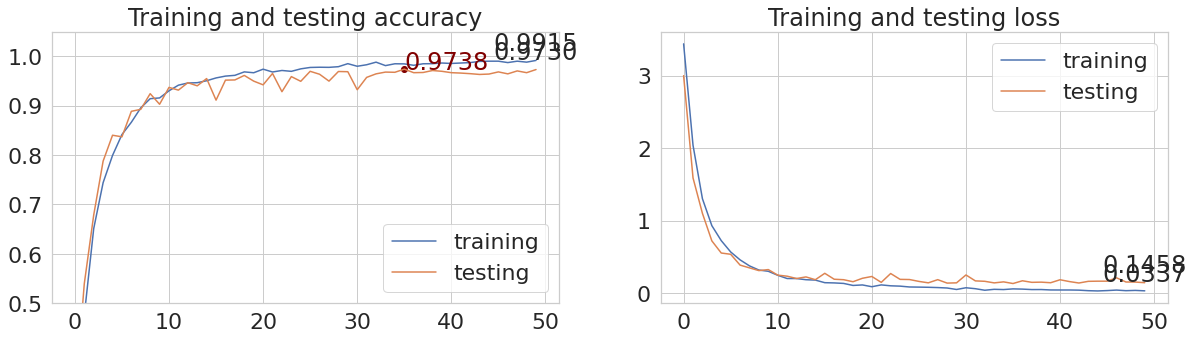

In [30]:
plot_history(history_v2_mix)

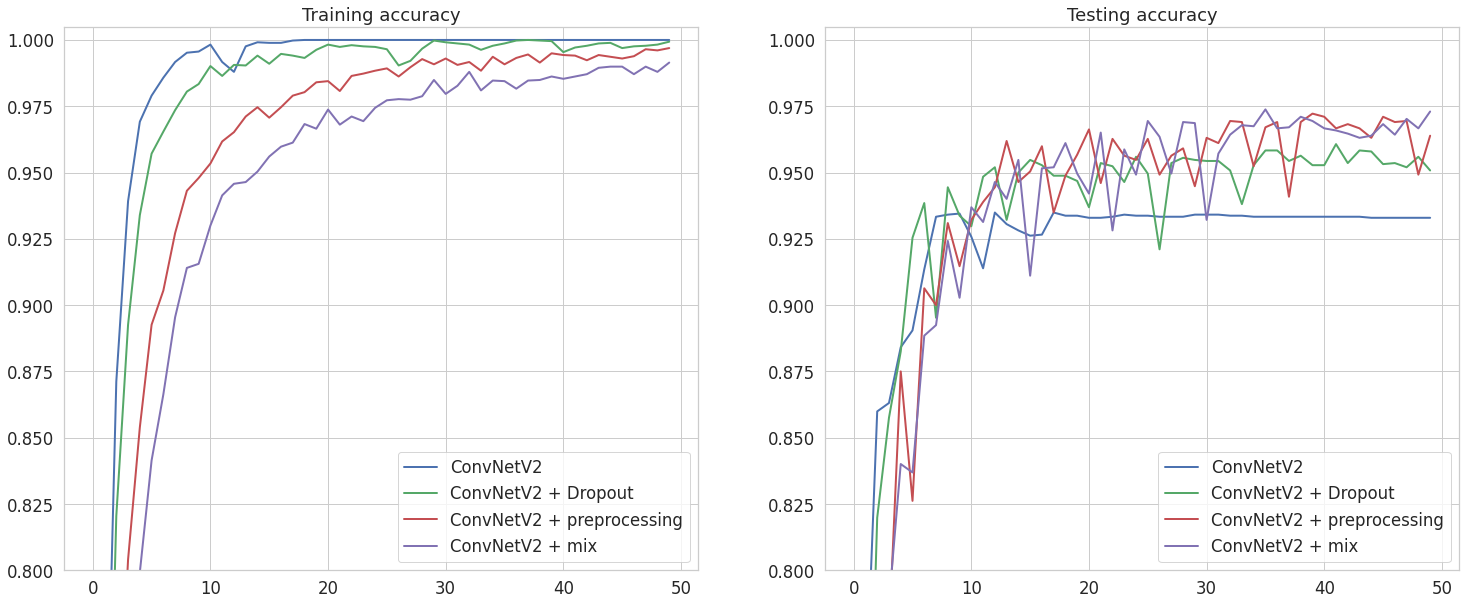

In [33]:
histories = {
             'ConvNetV2': history_v2, 
             'ConvNetV2 + Dropout': history_v2_dropout, 
             'ConvNetV2 + preprocessing': history_v2_preprocessing ,
             'ConvNetV2 + mix': history_v2_mix ,
             }
colors = ['b', 'g', 'r', 'm']

sns.set(style = 'whitegrid', font_scale = 1.5)
plt.figure(figsize = (25,10))
plt.subplot(1, 2, 1)
for idx, (l, h) in enumerate(histories.items()):
  val_acc = h.history['accuracy']
  epochs = range(len(val_acc))

  plt.plot(epochs, val_acc, 'b', label='%s' % l, color = colors[idx], linewidth=2.0)
  plt.ylim([0.8, 1.005])
  plt.title('Training accuracy')
  plt.legend()

plt.subplot(1, 2, 2)
for idx, (l, h) in enumerate(histories.items()):
  val_acc = h.history['val_accuracy']
  epochs = range(len(val_acc))

  plt.plot(epochs, val_acc, 'b', label='%s' % l, color = colors[idx], linewidth=2.0)
  plt.title('Testing accuracy')
  plt.ylim([0.8, 1.005])
  plt.legend()

In [34]:
!git add -A

^C
